In [1]:
import PIL
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.functional import F


import torchvision
from torchvision.ops import nms
from torchvision.ops import RoIPool

from torchvision.ops import boxes as box_ops

import pandas as pd
import os
from tqdm.notebook import trange, tqdm
import cv2

In [2]:
use_cuda = True
device = torch.device('cuda:4' if use_cuda else 'cpu')
x = torch.Tensor([0]).cuda(device)

# 1. 画框框之类的

In [3]:
# dataset的路径
path = 'data/car-object-detection/data/'

In [4]:
'''
    image file name: array([bbox1,bbox2])
'''
train_bbox_pd = pd.read_csv(path + 'train_solution_bounding_boxes.csv')
train_bbox_np = train_bbox_pd.to_numpy()
train_bbox = {}
for d in train_bbox_np:
    if d[0] not in train_bbox:
        train_bbox.update({d[0]:[d[1:]]})
    else:
        train_bbox[d[0]].append(d[1:])
train_bbox = {d:np.array(train_bbox[d]) for d in train_bbox}

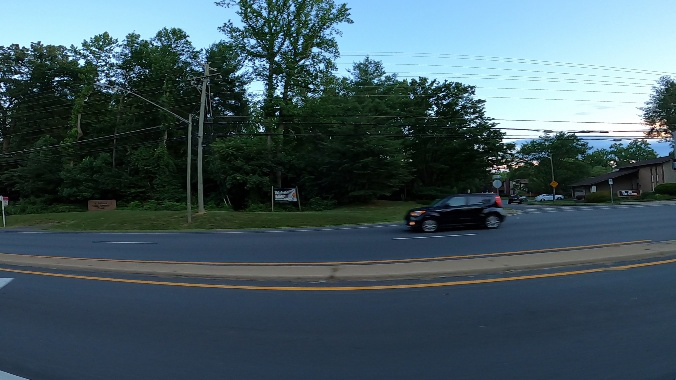

In [5]:
samplename = 'vid_4_10980.jpg'
img = Image.open(path + 'training_images/' + samplename)
img

In [6]:
train_bbox[samplename][0][2:]

array([518.0057887, 236.9192407], dtype=object)

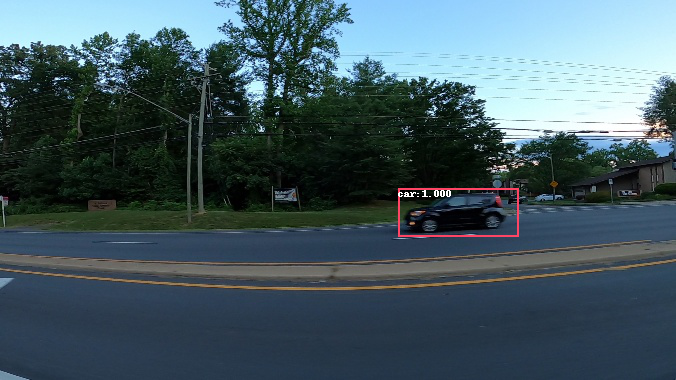

In [7]:
img11 = Image.open(path + 'training_images/' + samplename)
img = img11.copy()
img11.close()
pre = {'boxes':train_bbox[samplename],'scores':np.ones(len(train_bbox[samplename]))}
def drawbbox(img, pre, keep = None):
    img1 = img.copy()
    ImageD = ImageDraw.Draw(img1)
    for i in range(len(pre['boxes'])):
        if keep is not None and i not in keep:
            continue
        box = pre['boxes'][i]
        ImageD.rectangle([(box[0],box[1]),box[2],box[3]],outline='#FF4565',width = 2)
        score = pre['scores'][i]
        ImageD.text((box[0],box[1]),'car:{score:.3f}'.format(score=score),fill = '#FFFFFF')
    return img1
img1 = drawbbox(img,pre)
img1

# 2. Dataloader

In [8]:
# dataset的路径
path = 'data/car-object-detection/data/'
train_imagefile = [i for i in os.listdir(path + 'training_images') if i[-3:] == 'jpg']
test_imagefile = [i for i in os.listdir(path + 'testing_images') if i[-3:] == 'jpg']

In [9]:
class cardset(torch.utils.data.Dataset):
    def __init__(self, path = 'data/car-object-detection/data/'):
        super(cardset, self).__init__()
        self.path = path
        # 读取图像文件名
        self.train_imagefile = [i for i in os.listdir(path + 'training_images') if i[-3:] == 'jpg']
        self.test_imagefile = [i for i in os.listdir(path + 'testing_images') if i[-3:] == 'jpg']
        self.train_img = []
        self.test_img = []
        # 读取训练集的bbox
        train_bbox_pd = pd.read_csv(self.path + 'train_solution_bounding_boxes.csv')
        self.train_bbox_np = train_bbox_pd.to_numpy()
        self.train_bbox = {}
        self.idx2file = {}
        self.file2idx = {}
        i = 0
        for d in self.train_bbox_np:
            if d[0] not in self.train_bbox:
                self.train_bbox.update({d[0]:[d[1:]]})
                self.idx2file.update({i:d[0]})
                self.file2idx.update({d[0]:i})
                i += 1
            else:
                self.train_bbox[d[0]].append(d[1:])
        self.train_bbox = {d:np.array(self.train_bbox[d],dtype = np.float32) for d in self.train_bbox}
        # 读取数据到内存
        for filename in tqdm(self.train_imagefile,desc = 'Reading train data'):
            img = Image.open(path + 'training_images/' + filename)
            self.train_img.append([filename,img])
            if filename not in self.train_bbox:
                self.train_bbox.update({filename:[]})
                self.idx2file.update({i:filename})
                self.file2idx.update({filename:i})
                i += 1
                
        for filename in tqdm(self.test_imagefile,desc = 'Reading test data'):
            img = Image.open(path + 'testing_images/' + filename)
            self.test_img.append([filename,img])
            
    def __getitem__(self, index):
        if isinstance(self.train_img[index][1],(Image.Image)):
            self.train_img[index][1] = torchvision.transforms.functional.pil_to_tensor(self.train_img[index][1])/255
        img = self.train_img[index][1]
#         print(self.train_bbox[self.train_img[index][0]])
        label_num = self.file2idx[self.train_img[index][0]]
        return img, label_num
    
    def __len__(self):
        return len(self.train_img)

In [10]:
car = cardset()

Reading train data:   0%|          | 0/1001 [00:00<?, ?it/s]

Reading test data:   0%|          | 0/175 [00:00<?, ?it/s]

In [11]:
car_dataloader = torch.utils.data.DataLoader(car, batch_size = 8, shuffle = True, num_workers = 0,pin_memory = True,drop_last = True)

In [12]:
myiter = tqdm(car_dataloader,colour = '#0066FF')
myiter.set_description_str('car dataloader')
for x,y in myiter:
    pass

  0%|          | 0/125 [00:00<?, ?it/s]

# 3. model

In [13]:
# backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# backbone.out_channels = 2048

In [14]:
resnet_model = torchvision.models.resnet50(pretrained = True)
'''
    特征提取网络，不使用FPN
'''
features_list = [
                    resnet_model.conv1,
                    resnet_model.bn1,
                    resnet_model.relu,
                    resnet_model.maxpool,
                    resnet_model.layer1,
                    resnet_model.layer2,
                    resnet_model.layer3,
                ]
backbone = nn.Sequential(*features_list)
backbone.out_channels = 1024

In [15]:
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

In [16]:
anchor_generator = torchvision.models.detection.rpn.AnchorGenerator( sizes=((16, 32, 64, 128, 256, 512),),
                                    aspect_ratios=((0.5, 1.0, 2.0),))

In [17]:
faster_rcnn = torchvision.models.detection.FasterRCNN(backbone,
                                        num_classes = 2,
                                        min_size = 200,
                                        max_size = 5000,
                                        rpn_anchor_generator=anchor_generator,
                                        box_roi_pool=roi_pooler)
faster_rcnn.to(device)
x,y = iter(car_dataloader).next()
x = x.cuda(device)

In [18]:
# target = [{'boxes':torch.Tensor(car.train_bbox[car.idx2file[int(i)]])} for i in y]
x,y = iter(car_dataloader).next()
x = x.cuda(device)
def getTarget(x,y):
    target = []
    for i in y:
        t = car.train_bbox[car.idx2file[int(i)]]
        shape = len(t)
        label = 1
        if len(t) == 0:
            t = [[0,0,x.shape[-1],x.shape[-2]]]
            shape = 1
            label = 0
        target.append({'boxes':torch.Tensor(t).cuda(device), 'labels': torch.from_numpy(np.zeros(shape, dtype = np.int64) + label).cuda(device)})
    return target
target = getTarget(x,y)
target

[{'boxes': tensor([[238.2142, 198.7725, 409.4153, 251.1020],
          [  0.0000, 193.8819,  56.2518, 233.4958]], device='cuda:4'),
  'labels': tensor([1, 1], device='cuda:4')},
 {'boxes': tensor([[  0.,   0., 676., 380.]], device='cuda:4'),
  'labels': tensor([0], device='cuda:4')},
 {'boxes': tensor([[  0.,   0., 676., 380.]], device='cuda:4'),
  'labels': tensor([0], device='cuda:4')},
 {'boxes': tensor([[ 28.3705, 188.0132, 221.0941, 255.5035]], device='cuda:4'),
  'labels': tensor([1], device='cuda:4')},
 {'boxes': tensor([[  0.,   0., 676., 380.]], device='cuda:4'),
  'labels': tensor([0], device='cuda:4')},
 {'boxes': tensor([[ 75.8177, 196.8163, 229.8987, 250.6129],
          [423.1114, 175.7867, 554.2026, 228.6052]], device='cuda:4'),
  'labels': tensor([1, 1], device='cuda:4')},
 {'boxes': tensor([[  0.,   0., 676., 380.]], device='cuda:4'),
  'labels': tensor([0], device='cuda:4')},
 {'boxes': tensor([[ 81.1983, 197.5804, 171.2012, 235.9411],
          [ 52.8278, 198.2835, 1

In [19]:
optimizer = optim.AdamW(faster_rcnn.parameters(), 0.001)

In [ ]:
faster_rcnn.train()
Epoch = 10
for epoch in trange(Epoch,desc = 'Epoch'):
    myiter = tqdm(car_dataloader,colour = '#0066FF')
    myiter.set_description_str('Training')
    for x,y in myiter:
        x = x.cuda(device)
        target = getTarget(x,y)
        loss_dict = faster_rcnn(x,target)
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        myiter.set_postfix(loss = float(loss),epoch = epoch)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
torch.save(faster_rcnn,'model/faster_rcnn_car1.pt')

In [ ]:
faster_rcnn.eval()
f_name,img = car.test_img[77]
x = torchvision.transforms.functional.pil_to_tensor(img).unsqueeze(0).cuda(device)/255
pred = faster_rcnn(x)[0]
drawbbox(img, pred)

In [ ]:
s = 0.3
pred1 = {'boxes': torch.Tensor([pred['boxes'][i].cpu().detach().numpy() for i in range(len(pred['scores'])) if pred['scores'][i] >= s]),
         'labels':torch.Tensor([pred['labels'][i].cpu() for i in range(len(pred['scores'])) if pred['scores'][i] >= s]),
         'scores':torch.Tensor([pred['scores'][i].cpu() for i in range(len(pred['scores'])) if pred['scores'][i] >= s])}
drawbbox(img, pred1)

In [ ]:
if pred1['boxes'].numel() > 0:
    keep = torchvision.ops.nms(pred1['boxes'],pred1['scores'],0.3)
else:
    keep = None
drawbbox(img, pred1,keep)

In [ ]:
0.1+0.2